In [105]:
import astropy.io.fits as fits
import numpy as np
import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.visualization import simple_norm
import ccdproc as ccd
from astropy import visualization as viz
from astropy.visualization import (imshow_norm, MinMaxInterval,
                                   SqrtStretch, ZScaleInterval)

In [17]:
ls /home/savannahgramze/Documents/ObsAstronomy/ObsData/LabTwoData/WASP10_15sep10/WASP10_15sep10

calib/  science/


In [18]:
data = '/home/savannahgramze/Documents/ObsAstronomy/ObsData/LabTwoData/WASP10_15sep10/WASP10_15sep10'
calibration = '/home/savannahgramze/Documents/ObsAstronomy/ObsData/LabTwoData/WASP10_15sep10/WASP10_15sep10/calib/*'
science = '/home/savannahgramze/Documents/ObsAstronomy/ObsData/LabTwoData/WASP10_15sep10/WASP10_15sep10/science/*'

# Calibration

In [29]:
cali = glob.glob(calibration)
bias = []
flat = []

for cc in cali:
    if fits.getheader(cc)['object'] == 'zero':
        bias.append(fits.getdata(cc))
        #np.append(bias, fits.getdata(cc))
    elif fits.getheader(cc)['object'] == 'flat':
        #np.append(flat, fits.getdata(cc))
        flat.append(fits.getdata(cc))

In [31]:
np.shape(bias)

(100, 1365, 1365)

In [32]:
np.shape(flat)

(100, 1365, 1365)

In [33]:
master_bias = np.median(bias, axis=0)

In [34]:
master_flat = np.median(flat-master_bias, axis=0)

/tmp/ipykernel_421/3948988080.py:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(master_bias, norm=norm, vmin=0, vmax=500)


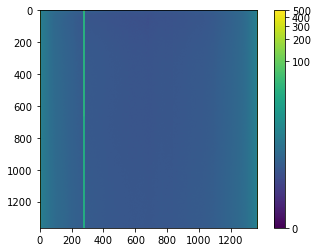

In [69]:
norm = simple_norm(master_bias, 'log')
plt.imshow(master_bias, norm=norm, vmin=0, vmax=500)
plt.colorbar()

In [59]:
master_bias.mean()

5.491103

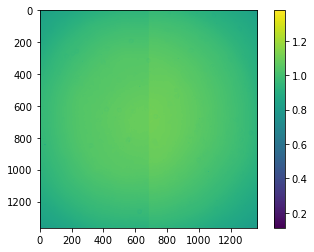

In [55]:
master_flat_norm = master_flat/np.median(master_flat)
plt.imshow(master_flat_norm)
plt.colorbar()

In [61]:
master_flat_norm.mean()

0.99360096

### Questions

1. What is the typical value of the bias? Is there structure in your bias frame? How do you interpret that? 

The typical value of the bias is 5.49. There is structure in the bias frame, mainly a bad column and gradients near the edges of the image.

2. Do you see structure in your flat field? What is the value in the center of the normalized flat compared to closer to the edge?

There is structure in the flat field, as the center of the image has values closer to 1, and the edges have values closer to 0.

In [70]:
calibrated = '/home/savannahgramze/Documents/ObsAstronomy/ObsData/LabTwoData/WASP10_15sep10/WASP10_15sep10/calibrated_images/'

In [85]:
s = glob.glob(science)
for ss in s:
    data = fits.getdata(ss)
    bias_subtracted = data - master_bias
    flat_corrected = data / master_flat_norm
    fits.writeto(calibrated+ss[-16:], flat_corrected, fits.getheader(ss))
    #print(calibrated+ss[-16:])

In [86]:
WASP_x = 2656
WASP_y = 2006

# Science Analysis

In [87]:
images = glob.glob(calibrated+'*')

In [117]:
im1 = fits.getdata(images[0])
im1 = im1-np.median(im1)

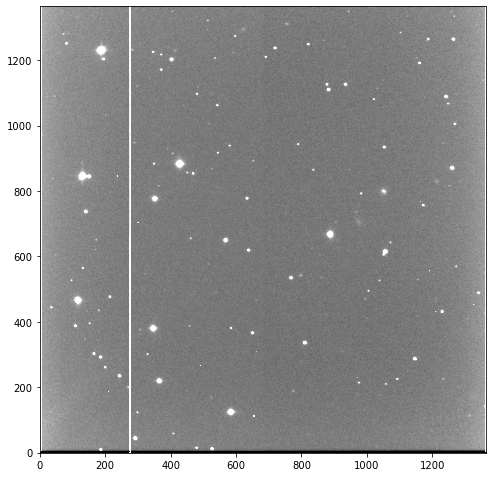

In [126]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(im1, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [129]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
bkg_sigma = mad_std(im1)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(im1)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)

 id xcentroid ycentroid sharpness   roundness1   roundness2  npix sky     peak       flux        mag     
--- --------- --------- ---------- ------------ ------------ ---- --- ----------- --------- -------------
  1  216.2333 8.8077412 0.69821986 -0.054166079  -0.67016891   25   0   3.7465134 1.0318393  -0.034030111
  2 498.93567   8.84249 0.52212849    0.2224495  -0.69445172   25   0   3.4938927 1.0213544    -0.0229412
  3 616.83197 9.2377362 0.33183101  -0.10922273  -0.24656386   25   0 0.082725525 1.0290469  -0.031087914
  4 769.51738  8.986771 0.34692978   -0.0684705   -0.7021654   25   0   -1.037838 1.1129563   -0.11619527
  5 464.38803 9.5124871 0.52383947  -0.67387325   -0.2176457   25   0   3.6798744 1.1213405   -0.12434378
  6 861.45881 9.7360218  0.8454539   0.21996097  -0.21653527   25   0   7.8711777 1.0013295 -0.0014425723
  7 950.08786 9.9731711 0.30934356  -0.20777698  -0.74433162   25   0   1.3345337 1.0337918  -0.036082687
  8 185.38295 10.042595 0.52500669  -0.1231164